# Cocktail Party Problem using Fourth Order Blind Identification(FOBI)

## Premise
You are at a party, trying to rizz up this gorgeous woman. You tell a few jokes, and you can tell that she's into you. You want to keep the conversation going but all the noise is making it difficult for you to understand what the mother of your future children is saying to you. How do you focus on her voice and tune out the noise?

This is the "Cocktail Party Problem", a source separation problem from signal processing. Here, we demonstrate the use of the "Fourth Order Blind Identification" algorithm to separate out the sources from a data received by different sensors (the microphones). 


## Why Fourth order?
So I'm not really familiar with DSP, I just like the challenge posed by the Cocktail Party Problem (which is why you're reading this document), but from what I understand, for most of the things, Gaussian distribution, or an approximation of the Gaussian gives a satisfactory result. So for the most part, poeple are content with first-order (mean) and second-order (variance) information. That being said, sound waves are not really Gaussian. So because sound waves are much more complex than what a Gaussian model could describe, we need to go beyond second-order information statistics. Apparently even the third order statistics weren't enough (otherwise they wouldn't have gone to fourth). Hence, we find ourselves dealing with fourth order statistics. 


## The Sounds

We create our own sensor data, by taking two source sounds and mixing them.

In [148]:
import IPython
import IPython.display

IPython.display.Audio("sounds/sources/conference.wav")

In [149]:
IPython.display.Audio("sounds/sources/sports.wav")

## Importing the sounds

There are some sources present in the `sounds/sources` folder, that you can experiment with, but any .wav file can be used.

In [150]:
from scipy.io import wavfile

source_x = wavfile.read("sounds/sources/sports.wav")     ########### Source 1 path here
source_y = wavfile.read("sounds/sources/conference.wav") ########### Source 2 path here

rate_x, data_x = source_x
rate_y, data_y = source_y

rate = min(rate_x, rate_y)
data_len = min(len(data_x), len(data_y)) # Ensuring that the audio data is of same length
data_x = data_x[:data_len]
data_y = data_y[:data_len]

## Plotting a soundwave

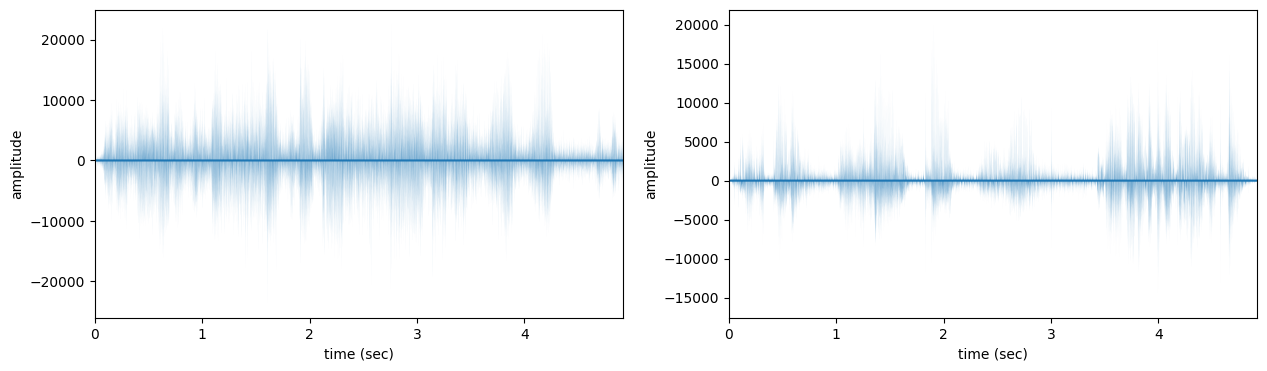

In [151]:
import matplotlib.pyplot as plt
import numpy as np

def plotWaves(sounds, samplerate=32000):
    fig = plt.figure(figsize=(15, 4))
    img_coor = 100 + 10*2 + 1
    for data in sounds:
        fig.add_subplot(img_coor)
        times = np.arange(len(data)) / float(samplerate)
        plt.fill_between(times, data)
        plt.xlim(times[0], times[-1])
        plt.xlabel("time (sec)")
        plt.ylabel("amplitude")
        plt.plot(data)

        img_coor += 1
    plt.show()

sounds = (data_x, data_y)
plotWaves(sounds, rate)

## Mixing the two sound waves

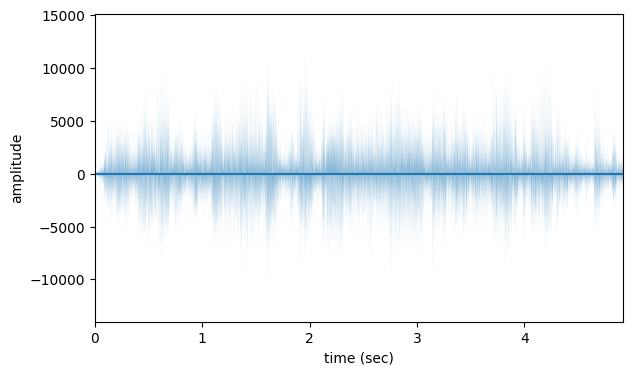

In [152]:
# Assuming that the sound waves are of equal length
def mixWaves(sounds, weights):
    combined_wave = np.zeros(len(sounds[0]))
    for sound, weight in zip(sounds, weights):
        combined_wave += sound*weight
    return combined_wave.astype(np.int16)

sounds = (data_x, data_y)
weights = (0.5, 0.5)

combined_wave = mixWaves(sounds, weights)
plotWaves((combined_wave,), rate)

In [172]:
mix_factor = 0.5
mixed_x = mixWaves(sounds, (1-mix_factor, mix_factor))
mixed_y = mixWaves(sounds, (mix_factor, 1-mix_factor))

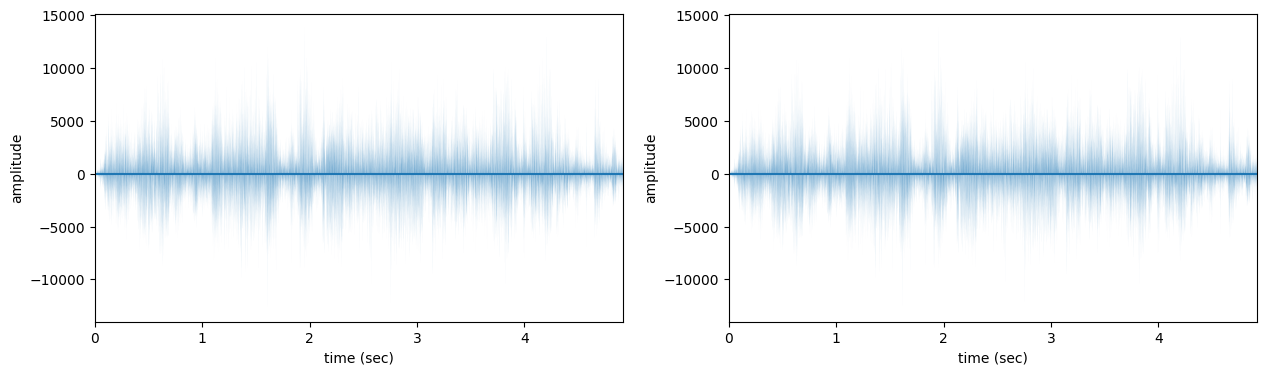

In [173]:
wavfile.write("sounds/mixed/mixed1.wav", rate, mixed_x)
wavfile.write("sounds/mixed/mixed2.wav", rate, mixed_y)

plotWaves((mixed_x, mixed_y), rate)

In [174]:
IPython.display.Audio("sounds/mixed/mixed1.wav")

In [175]:
IPython.display.Audio("sounds/mixed/mixed2.wav")

## Preprocessing the sounds vectors


So a big thing in FOBI is the orthonormalization of the input matrix. This is done to remove second-order dependencies. Any structures or features we detect after orthonormalization are solely due to higher order interactions. The `X` that we get as the result of the `orthonormalize` function has the covariance matrix ***I***.

In [176]:
data_x = data_x - data_x.mean()
data_x = data_x/rate
data_y = data_y - data_y.mean()
data_y = data_y/rate

X = np.stack((data_x, data_y))

In [192]:
def orthonormalize(X, fudge=1E-18):
    # Getting the covariance of matrix
    x_cov = np.dot(X, X.T)
    
    # Eigenvalue decomposition of the covariance matrix
    d, V = np.linalg.eigh(x_cov)
    
    # Adding a "fudge" factor to prevent over-amplification of the 
    # eigenvalues
    D = np.diag(1. / np.sqrt(d+fudge))
    
    # Whitening matrix
    C_inv = np.dot(np.dot(V, D), V.T)
    
    # Multiply by the whitening matrix
    x_white = np.dot(C_inv, X)
    
    return x_white

X = orthonormalize(X)

In [191]:
np.dot(X, X.T)  # Almost I. Close enough.

array([[ 1.0000000e+00, -1.5273976e-17],
       [-1.5273976e-17,  1.0000000e+00]])

## Implementing Fourth Order Blind Indentification (FOBI)

Here we use the fourth order moments at line 4, in the `weigthed_cov` matrix. 

In [196]:
def FOBI(X):
    norm_xn = np.linalg.norm(X, axis=0)
    norm = np.stack([norm_xn, norm_xn])  
    weighted_cov = np.cov(np.multiply(norm, X))
    d, Y = np.linalg.eigh(weighted_cov)
    source = np.dot(np.transpose(Y), X)
    return source

recreated_X = FOBI(X)
recreated_X *= 1000000 # Increasing the amplitude to actually hear

In [197]:
recreated_data_x = np.astype(recreated_X[0], np.int16)
recreated_data_y = np.astype(recreated_X[1], np.int16)

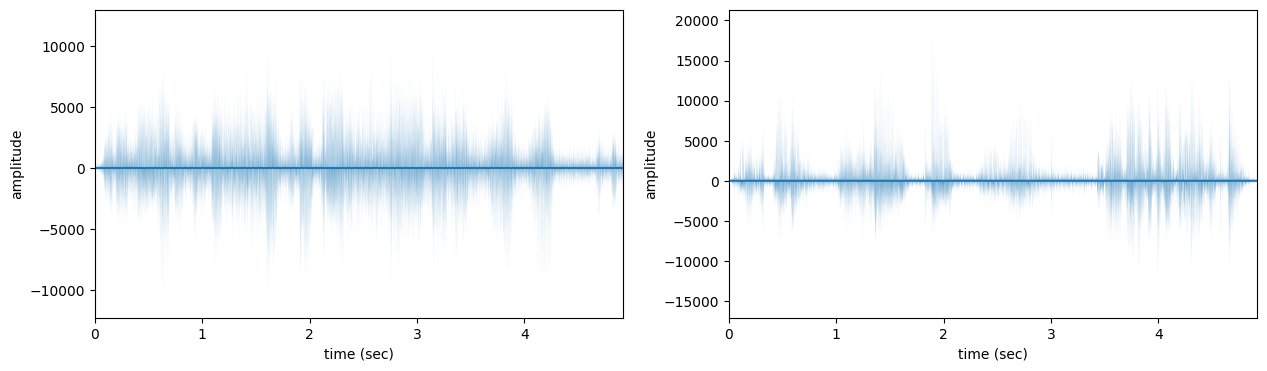

In [195]:
plotWaves([recreated_data_x, recreated_data_y], rate)

In [186]:
wavfile.write("sounds/separated/recreated_x.wav", rate, recreated_data_x)
IPython.display.Audio("sounds/separated/recreated_x.wav")

In [187]:
wavfile.write("sounds/separated/recreated_y.wav", rate, recreated_data_y)
IPython.display.Audio("sounds/separated/recreated_y.wav")